In [1]:
import os
import re

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, log_loss, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

### Stochastic Gradient Descent
- Goal of gradient descent is to minimize function by taking steps in direction fastest decreases
- vector of partial derivatives of a fucntion


In [2]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
PATH_TO_WRITE_DATA = "../../../data/tmp/"
data_demo = pd.read_csv(os.path.join(DATA_PATH, "weights_heights.csv"))

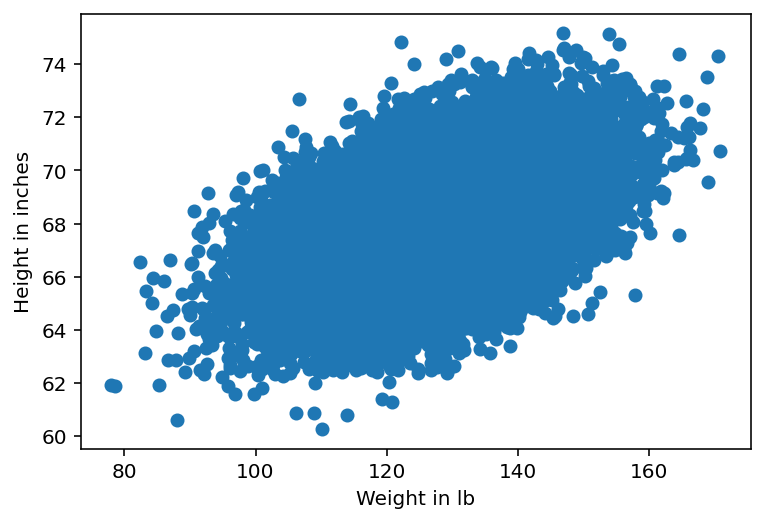

In [6]:
plt.scatter(data_demo["Weight"], data_demo["Height"])
plt.xlabel("Weight in lb")
plt.ylabel("Height in inches");

Stochastic gradient descent updates gradients/derivatives after a small batch of data, hence avoiding overfitting and vanishing/exploding gradients

In [7]:
df = pd.read_csv(os.path.join(DATA_PATH, "bank_train.csv"))
labels = pd.read_csv(
    os.path.join(DATA_PATH, "bank_train_target.csv"), header=None
)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


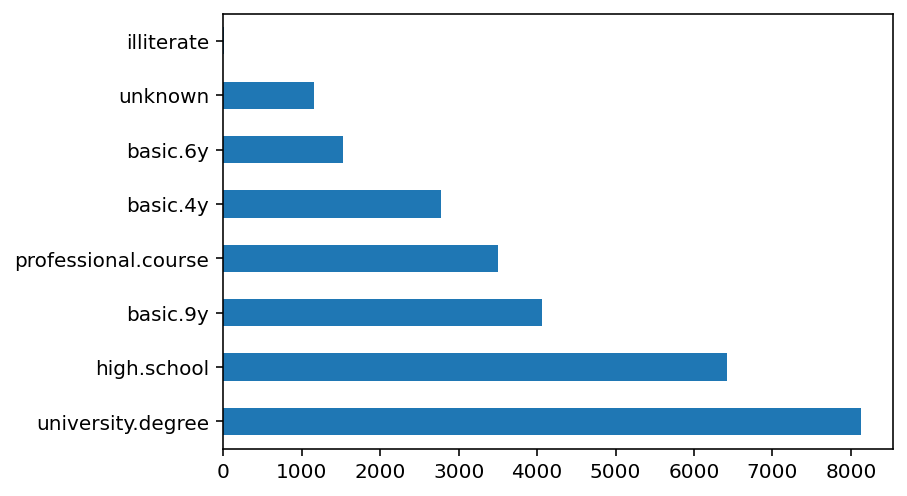

In [8]:
df["education"].value_counts().plot.barh();

{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}


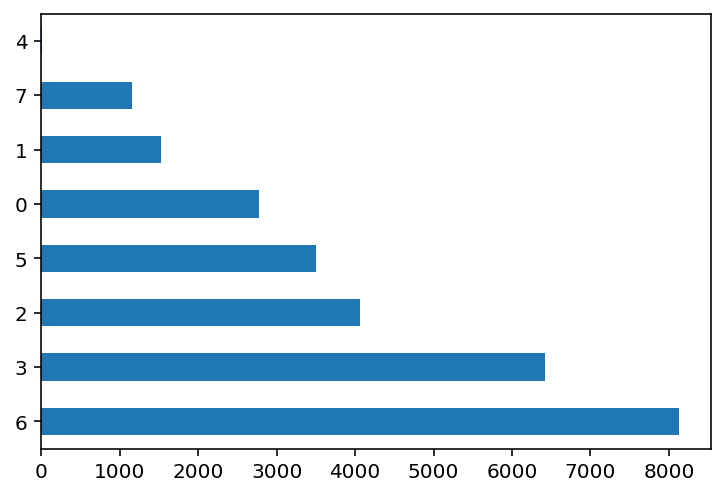

In [9]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(df["education"]))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [10]:
{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}

{0: 'basic.4y',
 1: 'basic.6y',
 2: 'basic.9y',
 3: 'high.school',
 4: 'illiterate',
 5: 'professional.course',
 6: 'university.degree',
 7: 'unknown'}

In [11]:
df["education"] = mapped_education
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,3,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,6,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,0,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,6,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,6,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


In [12]:
categorical_columns = df.columns[df.dtypes == "object"].union(["education"])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


In [13]:
df.loc[1].job - df.loc[2].job

-1.0

In [14]:
def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels
    )

    logit = LogisticRegression()
    logit.fit(train_features, train_labels)
    return classification_report(test_labels, logit.predict(test_features))


print(logistic_regression_accuracy_on(df[categorical_columns], labels))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6109
           1       0.00      0.00      0.00       790

    accuracy                           0.89      6899
   macro avg       0.44      0.50      0.47      6899
weighted avg       0.78      0.89      0.83      6899



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
one_hot_example = pd.DataFrame([{i: 0 for i in range(10)}])
one_hot_example.loc[0, 6] = 1
one_hot_example

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0


In [16]:
onehot_encoder = OneHotEncoder(sparse=False)

In [17]:
encoded_categorical_columns = pd.DataFrame(
    onehot_encoder.fit_transform(df[categorical_columns])
)
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [18]:
print(logistic_regression_accuracy_on(encoded_categorical_columns, labels))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6138
           1       0.63      0.19      0.29       761

    accuracy                           0.90      6899
   macro avg       0.77      0.59      0.62      6899
weighted avg       0.88      0.90      0.87      6899



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Hashing Trick
- Vectorization of categorical data

In [19]:
for s in ("university.degree", "high.school", "illiterate"):
    print(s, "->", hash(s))

university.degree -> -5583241800525428300
high.school -> 1063785552688624267
illiterate -> 1594664276044294683


In [20]:
hash_space = 25
for s in ("university.degree", "high.school", "illiterate"):
    print(s, "->", hash(s) % hash_space)

university.degree -> 0
high.school -> 17
illiterate -> 8


In [21]:
hashing_example = pd.DataFrame([{i: 0.0 for i in range(hash_space)}])
for s in ("job=student", "marital=single", "day_of_week=mon"):
    print(s, "->", hash(s) % hash_space)
    hashing_example.loc[0, hash(s) % hash_space] = 1
hashing_example

job=student -> 4
marital=single -> 11
day_of_week=mon -> 23


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
assert hash("no") == hash("no")
assert hash("housing=no") != hash("loan=no")

In [26]:
!vw --help | head

zsh:1: command not found: vw


Using the vowpal library to work with high dimensional categorical data and less features

In [27]:
# load data with sklearn's function
newsgroups = fetch_20newsgroups(data_home=DATA_PATH)

In [28]:
newsgroups["target_names"]

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [29]:
text = newsgroups["data"][0]
target = newsgroups["target_names"][newsgroups["target"][0]]

print("-----")
print(target)
print("-----")
print(text.strip())
print("----")

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


In [30]:
def to_vw_format(document, label=None):
    return (
        str(label or "")
        + " |text "
        + " ".join(re.findall("\w{3,}", document.lower()))
        + "\n"
    )


to_vw_format(text, 1 if target == "rec.autos" else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

In [31]:
def to_vw_format(document, label=None):
    return (
        str(label or "")
        + " |text "
        + " ".join(re.findall("\w{3,}", document.lower()))
        + "\n"
    )


to_vw_format(text, 1 if target == "rec.autos" else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

In [32]:
# train_documents, test_documents, train_labels, test_labels = train_test_split(
#     all_documents, all_targets, random_state=7
# )

# with open(os.path.join(PATH_TO_WRITE_DATA, "20news_train.vw"), "w") as vw_train_data:
#     for text, target in zip(train_documents, train_labels):
#         vw_train_data.write(to_vw_format(text, target))
# with open(os.path.join(PATH_TO_WRITE_DATA, "20news_test.vw"), "w") as vw_test_data:
#     for text in test_documents:
#         vw_test_data.write(to_vw_format(text))

NameError: name 'all_documents' is not defined

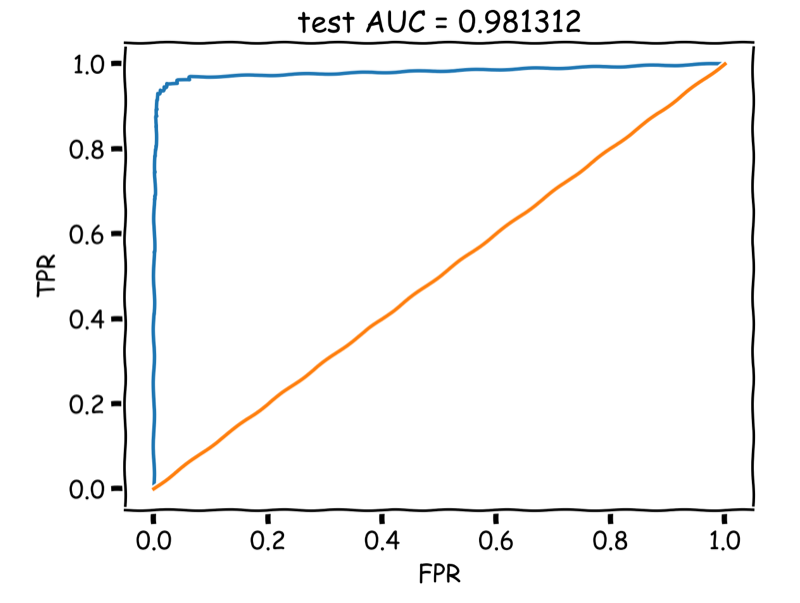

In [35]:
import tarfile
# Download the dataset if not already in place
from io import BytesIO

import requests

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"


def load_imdb_dataset(extract_path=DATA_PATH, overwrite=False):
    # check if existed already
    if (
        os.path.isfile(os.path.join(extract_path, "aclImdb", "README"))
        and not overwrite
    ):
        print("IMDB dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    tar = tarfile.open(mode="r:gz", fileobj=BytesIO(response.content))

    data = tar.extractall(extract_path)


load_imdb_dataset()

In [36]:
PATH_TO_IMDB = PATH_TO_WRITE_DATA + "aclImdb"

reviews_train = load_files(
    os.path.join(PATH_TO_IMDB, "train"), categories=["pos", "neg"]
)

text_train, y_train = reviews_train.data, reviews_train.target

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/tmp/aclImdb/train'

Summary
- Use Linear Regression and Stochastic Gradient Descent
- Vowpal Rabbit and smart NLP that is able to do more with less data